### This script contains the following:
    1. Importing Libraries
    2. Importing Data
    3. Get Weather Data Using NOAA's API
    4. Wrangling the Data
      4.1 Wrangle Weather Data
      4.2 Wrangle Bike Rental Data
    5. Merge the weather data with the New York CitiBike data set
    6. Export the Data
  

## 1. Importing Libraries

In [3]:
import pandas as pd 
import numpy as np
import os 
import requests
import json
import seaborn as sns
from datetime import datetime

## 2. Importing Data

In [5]:
# Create a list with all files in the folder using a list compehension
folderpath = "./Data/Original_data"
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]

In [6]:
# Read and concatenate all files simultaneously
df = pd.concat((pd.read_csv(f, low_memory=False, encoding="utf-8") for f in filepaths), ignore_index = True)

In [7]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BFD29218AB271154,electric_bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802117,-73.968181,40.804038,-73.945925,member
1,7C953F2FD7BE1302,classic_bike,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,4 Ave & 3 St,4028.04,Boerum Pl\t& Pacific St,4488.09,40.673746,-73.985649,40.688489,-73.991160,member
2,95893ABD40CED4B8,electric_bike,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,1 Ave & E 62 St,6753.08,5 Ave & E 29 St,6248.06,40.761227,-73.960940,40.745168,-73.986831,member
3,F853B50772137378,classic_bike,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2 Ave & E 96 St,7338.02,5 Ave & E 29 St,6248.06,40.783964,-73.947167,40.745168,-73.986831,member
4,7590ADF834797B4B,classic_bike,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,6 Ave & W 34 St,6364.10,5 Ave & E 29 St,6248.06,40.749640,-73.988050,40.745168,-73.986831,member


In [8]:
df.shape

(29838806, 13)

We joined a total of 36 csv files with 'os.listdir(folderpath)'technique, it is both faster for the coder and faster for the machine

## 3. Get Weather Data Using NOAA's API

In [11]:
# Define the NOAA token
Token = 'rImWOAcaGgUESfzZOtKKnlVnlAuambLL'

In [12]:
# Get the API 
r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid=GHCND:USW00014732&startdate=2022-01-01&enddate=2022-12-31', headers={'token':Token})

In [13]:
# Load the API response as a json
d = json.loads(r.text)

## 4. Wrangling the Data

### 4.1 Wrangle Weather Data

In [16]:
# Secure all items in the response that correspond to TAVG
avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']

In [17]:
# Create a list of the date from all average temperature readings
dates_temp = [item['date'] for item in avg_temps]

In [18]:
# Create a list of the temperature from all average temperature readings
temps = [item['value'] for item in avg_temps]

In [19]:
# Initialize a dataframe
df_temp = pd.DataFrame()

In [20]:
# Create two columns in the new dataframe corresponding to the two lists
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp] # Cast date to datetime
df_temp['avgTemp'] = [float(v)/10.0 for v in temps] # Convert temperature from tenths of Celsius to normal Celsius

In [21]:
df_temp.tail()

,date,avgTemp
360,2022-12-27,-0.7
361,2022-12-28,3.4
362,2022-12-29,6.4
363,2022-12-30,9.3
364,2022-12-31,8.2


<Axes: xlabel='date', ylabel='avgTemp'>

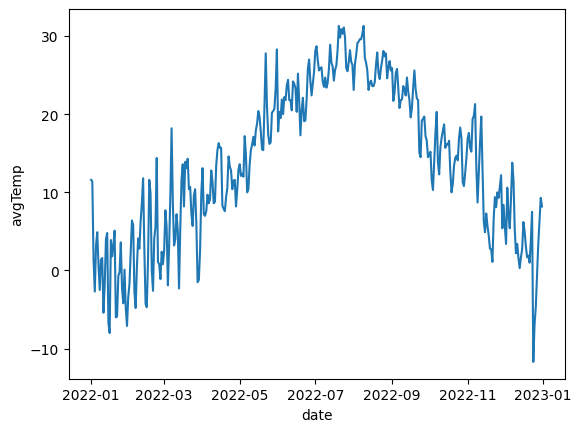

In [22]:
# Plot temperature by date in a line plot
sns.lineplot(data=df_temp, x="date", y="avgTemp")
# Checking the data to ensure data consistency

### 4.2 Wrangle Bike Rental Data

In [24]:
# Check the datatypes of df
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [25]:
# Convert 'started at' date to datetime
df['started_at'] = pd.to_datetime(df['started_at'], dayfirst = False)

In [26]:
# Create a new column in df that matches the 'date' column df_temps
df['date'] = pd.to_datetime(df['started_at'], format='%Y-%m-%d').dt.date 
df['date'] = pd.to_datetime(df['date'])

## 5. Merge the weather data with the New York CitiBike data set

In [28]:
# Left merge df with df_temp on the 'date' columns
df_merged = df.merge(df_temp, how = 'left', on = 'date', indicator = True)

In [29]:
# Check to see if it was a full match
df_merged['_merge'].value_counts(dropna = False)

both          29838166
left_only          640
right_only           0
Name: _merge, dtype: int64

In [30]:
# Subset merged dataframe to only contain the rows that didn't merge with df_temps
df_merged_left = df_merged.loc[df_merged['_merge'] == 'left_only']

In [31]:
df_merged_left.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,_merge
4967,9D2DEF9B6D4FE1F2,electric_bike,2021-12-31 23:56:04.967,2022-01-01 00:10:03.697,3 St & Prospect Park West,3865.05,Atlantic Ave & Furman St,4614.04,40.668132,-73.973638,40.691652,-73.999979,member,2021-12-31,NaN,left_only
8335,07F3FEAE54546CCC,classic_bike,2021-12-31 23:25:37.862,2022-01-01 00:40:26.455,Hudson St & W 13 St,6115.06,W 15 St & 6 Ave,5989.02,40.740057,-74.005274,40.738046,-73.996430,casual,2021-12-31,NaN,left_only
9102,F7054D918A815DED,electric_bike,2021-12-31 23:38:49.704,2022-01-01 00:29:24.363,E 85 St & 3 Ave,7212.05,E 81 St & 2 Ave,7121.05,40.778012,-73.954071,40.774779,-73.954275,member,2021-12-31,NaN,left_only
9178,302DA77D1C2677A4,electric_bike,2021-12-31 23:41:16.311,2022-01-01 00:03:43.417,Perry St & Greenwich Ave,5955.12,E 48 St & 3 Ave,6541.03,40.735918,-74.000939,40.754601,-73.971879,casual,2021-12-31,NaN,left_only
18361,7A6CD4B02003DA01,classic_bike,2021-12-31 23:45:39.596,2022-01-01 00:09:44.400,W 84 St & Columbus Ave,7382.04,Lexington Ave & E 120 St,7652.04,40.785000,-73.972834,40.801307,-73.939817,casual,2021-12-31,NaN,left_only


## 6. Export the Data

In [33]:
# Set the destination path for processed data (relative path)
destpath = "./Data/Prepared_data"
# Save the DataFrame to a CSV file at the destination path
df_merged.to_csv(os.path.join(destpath, 'nyc_bike_weather_data.csv'))

In [34]:
df_merged.shape

(29838806, 16)

In [35]:
# Set the destination path for processed data (relative path)
destpath = "./Data/Prepared_data"
# Save the DataFrame to a pkl file at the destination path
df_merged.to_pickle(os.path.join(destpath, 'nyc_bike_weather_data.pkl'))